<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/1023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install umap-learn[plot] hdbscan kneed

## HDBSCAN on digits and iris

In [2]:
# !{sys.executable} -m pip install hdbscan
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import hdbscan
from hdbscan.validity import validity_index

import umap
import umap.plot as uplot
from sklearn.datasets import fetch_openml, load_iris
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
from kneed import KneeLocator

sns.set_theme()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn

### Digits data

In [3]:
# Load digits data
mnist = fetch_openml('mnist_784', parser='auto')

# Normalize digits data
digits_data = mnist.data/255
digit_labels = mnist.target

# Subset the dataset
digit_labels_df = pd.DataFrame(digit_labels)

label_subset_df = digit_labels_df.groupby('class').head(2000)

digits_data = digits_data.loc[label_subset_df.index, :].reset_index(drop=True)
digit_labels = label_subset_df['class'].to_numpy()

<ipython-input-3-5c995778cebc>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_subset_df = digit_labels_df.groupby('class').head(2000)


Number of PCA components 784


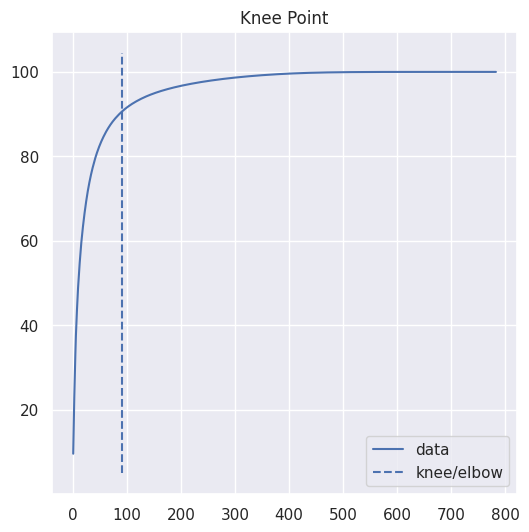

In [4]:
# because digits data has a high dimensionality, which is bad for hdbscan clustering,
# we will use PCA in order to to lower the dimensionality of our data while retaining as much information as possible

pca = PCA()
pca.fit(digits_data)
pca_transformed_data = pca.transform(digits_data)
print('Number of PCA components {}'.format(pca_transformed_data.shape[1]))
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)*100

kneedle = KneeLocator(
    range(len(cumulative_explained_variance)),
    cumulative_explained_variance,
    S=1.0,
    curve="concave",
    direction="increasing"
)
kneedle.plot_knee()

In [5]:
pca_dim_red = pca_transformed_data[:,:50]

<Axes: >

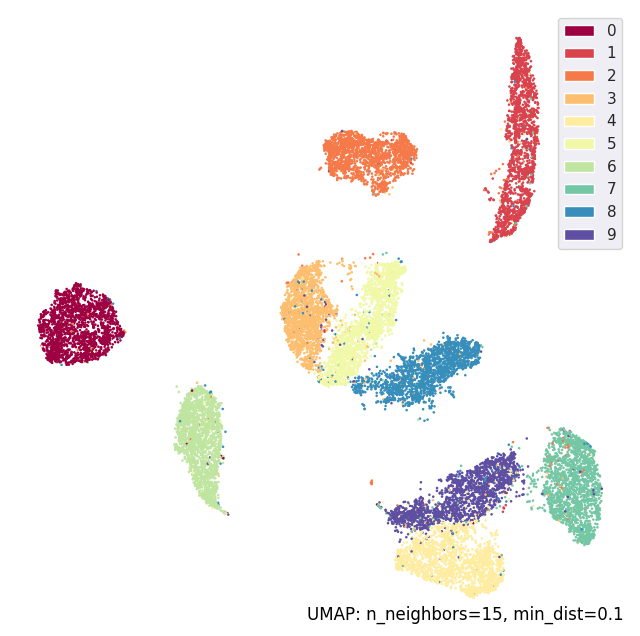

In [6]:
# Default values
umap_obj = umap.UMAP()
embedding = umap_obj.fit_transform(pca_dim_red)

uplot.points(umap_obj, labels=digit_labels)
# all of our digits are clearly visible on the Umap plot

In [7]:
# we will use this function in order to evaluate our clustering quality
# just like in the DBscan case, we will evaluate clustering results by using the complete data set and
# by using a non outlier data points
def print_clustering_stats(clusterer, clust_data, data_labels):
    # Create reduced version of data (exclude noise)
    np_labels = np.array(clusterer.labels_)
    non_noise_idx = np.where(np_labels != -1)

    non_noise_labels = np_labels[non_noise_idx]
    clust_labels_sub = data_labels[non_noise_idx]
    clust_data_sub = clust_data[non_noise_idx]
    noise_size = np_labels.shape[0] - non_noise_labels.shape[0]

    print('ARI : {}'.format(adjusted_rand_score(np_labels, data_labels)))
    print('ARI sub : {}'.format(adjusted_rand_score(non_noise_labels, clust_labels_sub)))
    print('noise size : {}'.format(noise_size))
    print('Silouethe : {}'.format(silhouette_score(clust_data, np_labels)))
    print('Silouethe sub : {}'.format(silhouette_score(clust_data_sub, clust_labels_sub)))
    print('DBCV : {}'.format(validity_index(clust_data, np_labels)))

ARI : 0.04421682050987232
ARI sub : 0.9965981781707013
noise size : 16972
Silouethe : -0.09949354482323984
Silouethe sub : 0.19458048751724055
DBCV : 0.005863904368002314


<Axes: >

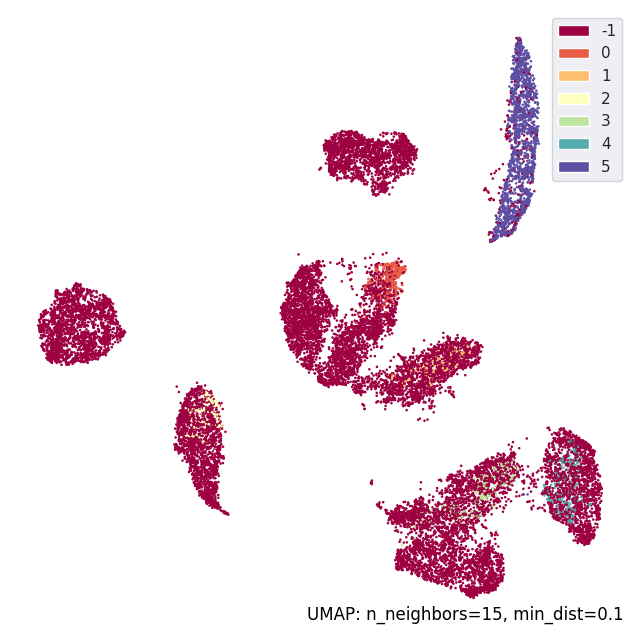

In [8]:
clusterer = hdbscan.HDBSCAN(
    min_samples=5,
    min_cluster_size=100
)
clusterer.fit(pca_dim_red)

print_clustering_stats(
    clusterer=clusterer,
    clust_data=pca_dim_red,
    data_labels=digit_labels
)

uplot.points(umap_obj, labels=clusterer.labels_)
# this doesn't look too good
# this is better compared to DBscan clustering, because we have managed to discover small clusters that
# are located inside of this bigger groups
# but still the number of noise data points is too high and the number of clusters is too low

ARI : 0.0620451604091957
ARI sub : 0.9949149740514572
noise size : 14873
Silouethe : -0.0946336623562824
Silouethe sub : 0.1854009565723897
DBCV : 0.0275406710127663


<Axes: >

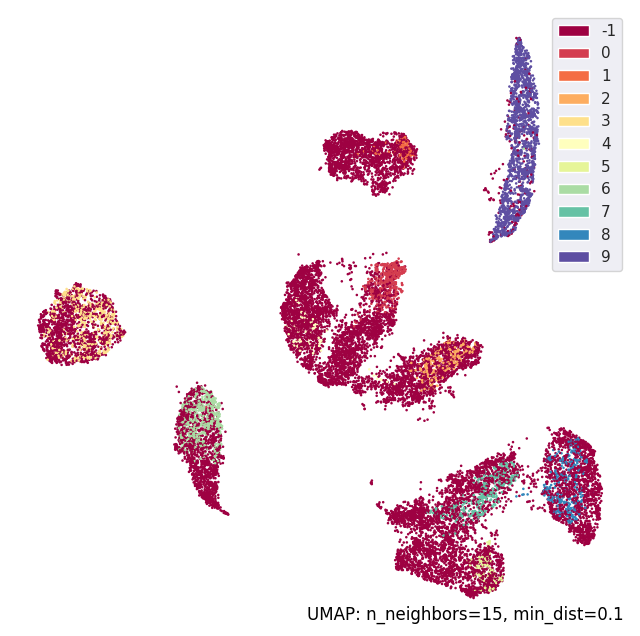

In [9]:
clusterer = hdbscan.HDBSCAN(
    min_samples=1, # lower the min_samples
    min_cluster_size=100,
    metric='euclidean'
)
clusterer.fit(pca_dim_red)

print_clustering_stats(
    clusterer=clusterer,
    clust_data=pca_dim_red,
    data_labels=digit_labels
)

uplot.points(umap_obj, labels=clusterer.labels_)
# the situation is now a bit better, but still far from good because still we have a 14,000 outlier data points, which is the majority of data points
# but also you can see that now we have managed to discover a ten clusters, and we have a cluster group inside of each of our groups corresponding to different digits
# and one interesting conclusion is that the adjusted rand score of non outlier data points is actually really high
# so even though majority of data points is declared as noise when it comes to data points that belong to clusters, these data points are actually clustered really well
# and this leads us to our final question: did we manage to cluster the data?
# the answer could actually depend on our perspective on this clustering
# if our goal was to cluster each and every data point, then clearly we have failed because the majority of data points are declared as noise
# on the other hand, if our goal was to find the dense areas inside of each of these groups where dense areas can be considered as representative samples for each of these groups, then we can say that we have succeeded to some extent
# the reason why Hdbscan clustering couldn't discover complete clusters is that densities not only are variable between our clusters, they are variable inside of our clusters, and for this reason, HDBscan has only managed to find the densest area inside of every of these groups

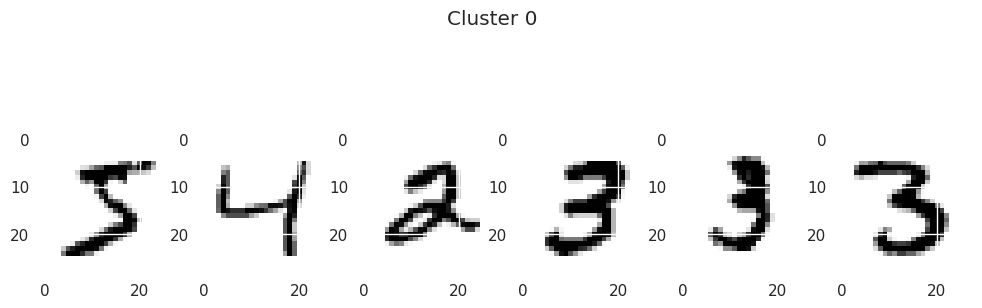

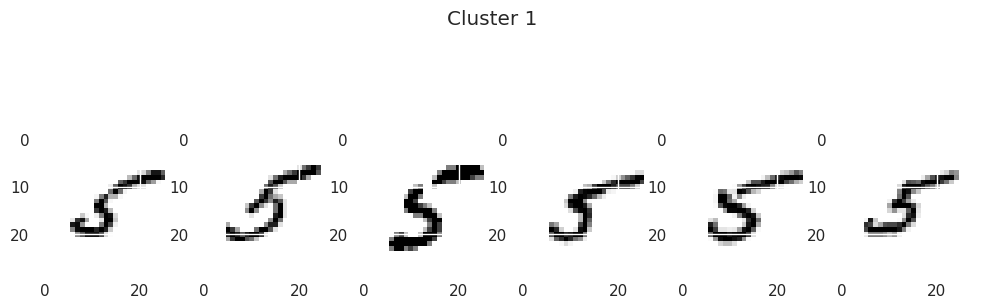

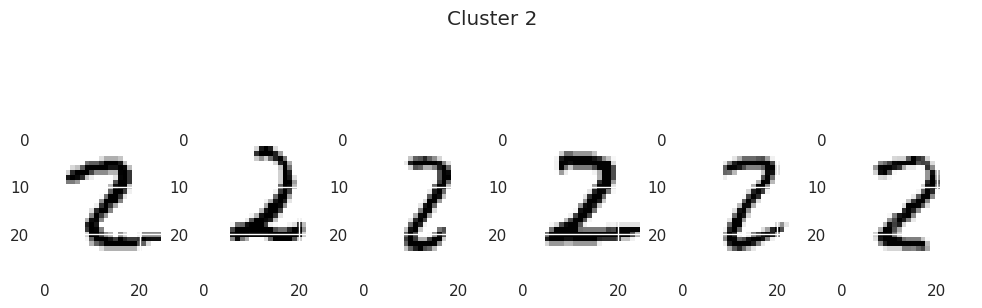

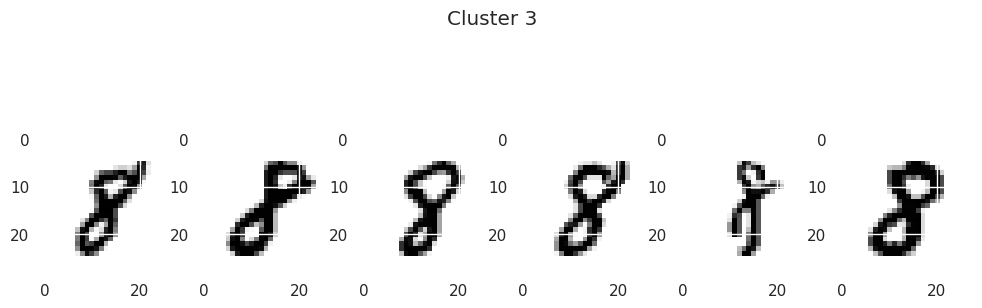

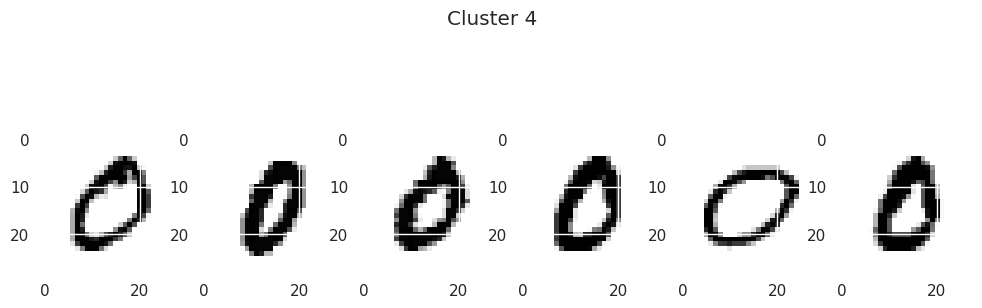

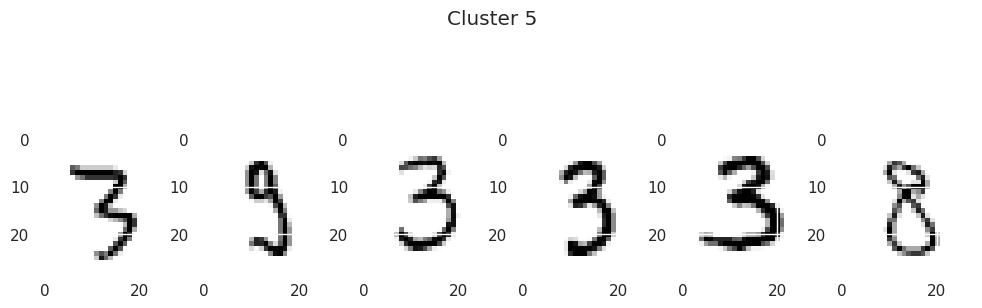

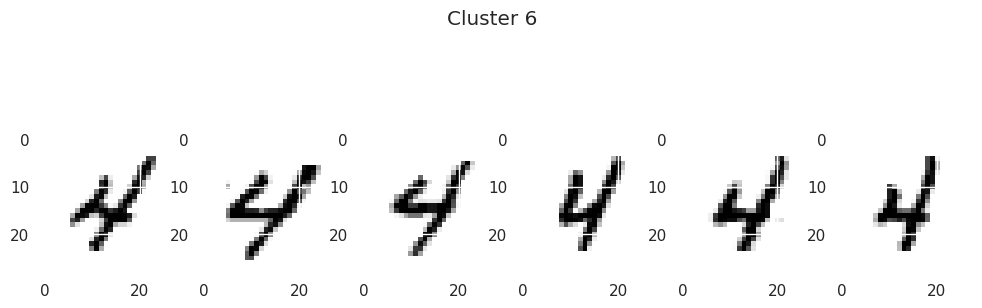

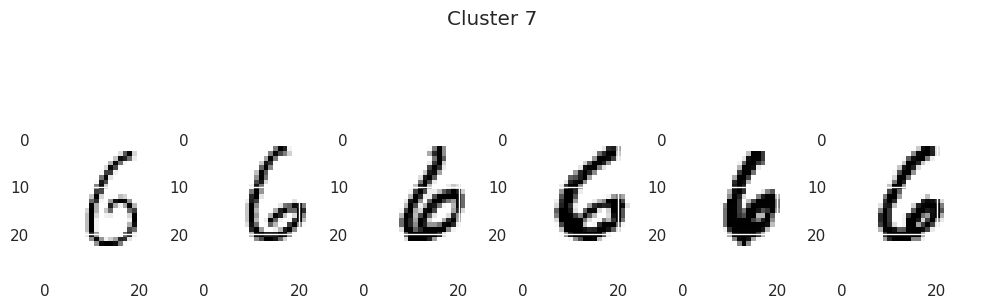

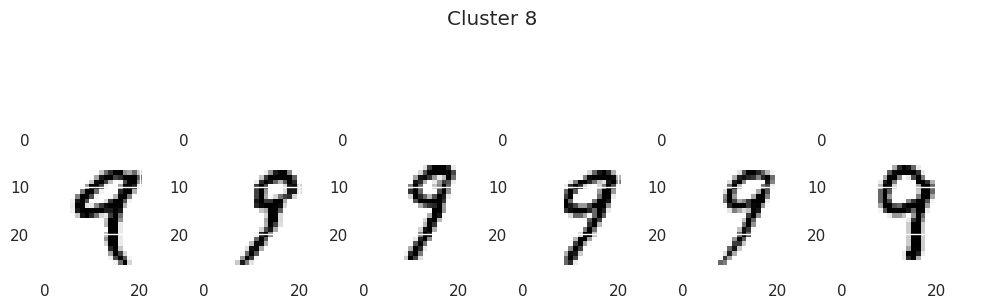

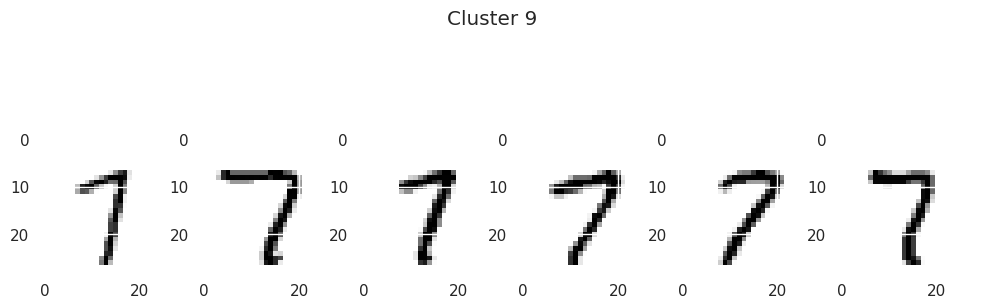

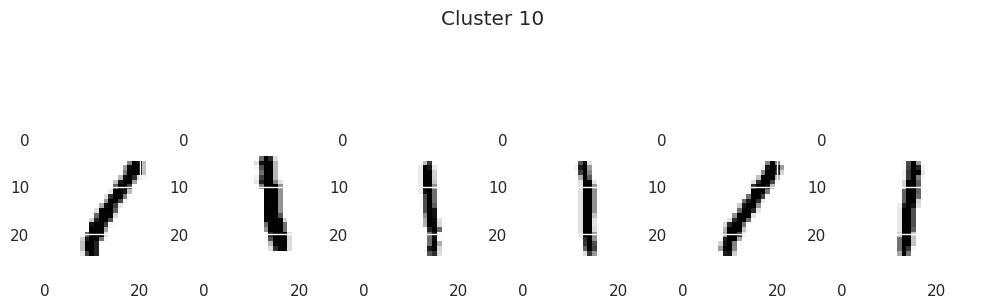

In [10]:
digits_data_rshp = np.reshape(digits_data, newshape=[digits_data.shape[0], 28, 28])

for clust_i, clust_name in enumerate(np.unique(clusterer.labels_)):
    clust_samples = np.where(clusterer.labels_==clust_name)[0]

    nrows = 1
    ncols = 6
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 4*nrows))  # Adjust the size as needed

    axs = axs.flatten()

    for i, img_idx in enumerate(clust_samples[:6]):
        axs[i].imshow(digits_data_rshp[img_idx], cmap=plt.cm.gray_r)
    fig.suptitle('Cluster {}'.format(clust_i))
# go on and plot several instances from each of our clusters
# with exception of 1 or 2 groups, instances from majority of clusters, seem to be pretty pure

ARI : 0.010403832576213518
ARI sub : 0.9363435641342195
noise size : 16930
Silouethe : -0.1468738453933628
Silouethe sub : 0.1997410498326197
DBCV : 0.013114385583955973


<Axes: >

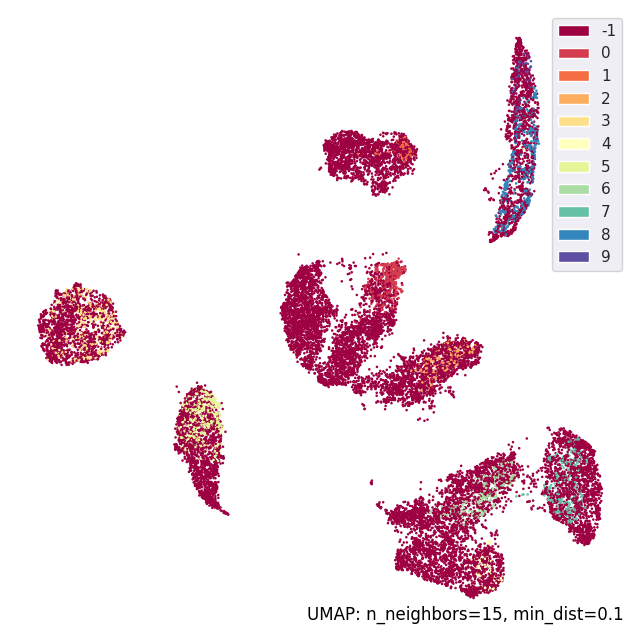

In [11]:
clusterer = hdbscan.HDBSCAN(
    min_samples=2,
    min_cluster_size=100,
    metric='euclidean',
    cluster_selection_method='leaf' # leaf clustering
)
clusterer.fit(pca_dim_red)

print_clustering_stats(
    clusterer=clusterer,
    clust_data=pca_dim_red,
    data_labels=digit_labels
)

uplot.points(umap_obj, labels=clusterer.labels_)
# this doesn't look bad
# this seems a bit worse compared compared to exccess of mass, because the clusters seem to be less clear and because the size of the noise is higher

### Iris data

Text(0.5, 1.0, 'Scatterplot with true label')

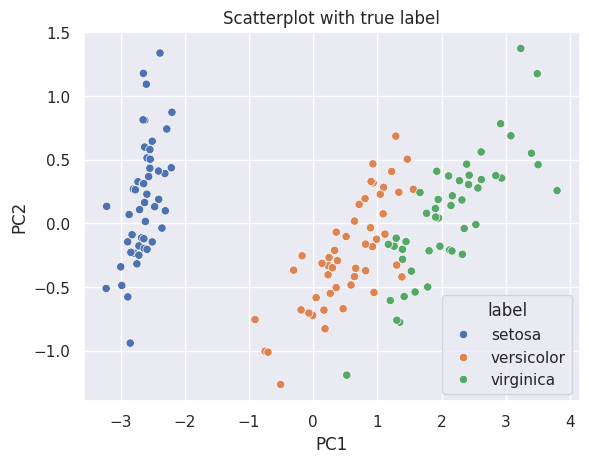

In [12]:
# let's try clustering a simpler data set

# Load iris dataset
iris = load_iris()

# Load iris dataset
iris_df = pd.DataFrame(
    iris['data'],
    columns=iris['feature_names']
)

numer_cols = iris_df.columns

# Load iris labels
iris_df['label'] = iris['target_names'][iris['target']]

# Run PCA so we can show dataset in 2D space
pca = PCA(n_components=2)
pca_data = pca.fit_transform(iris_df[numer_cols].to_numpy())
pca_data = np.column_stack([pca_data, iris_df['label'].to_numpy()])
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'label'])

# Plot and colour based on reference label
sns.scatterplot(pca_df, x='PC1', y='PC2', hue='label')
plt.title('Scatterplot with true label')

ARI : 0.5681159420289855
ARI sub : 0.5681159420289855
noise size : 0
Silouethe : 0.6867350732769777
Silouethe sub : 0.5034774406932961
DBCV : 0.6204492461686135


Text(0.5, 1.0, 'Scatterplot with true label')

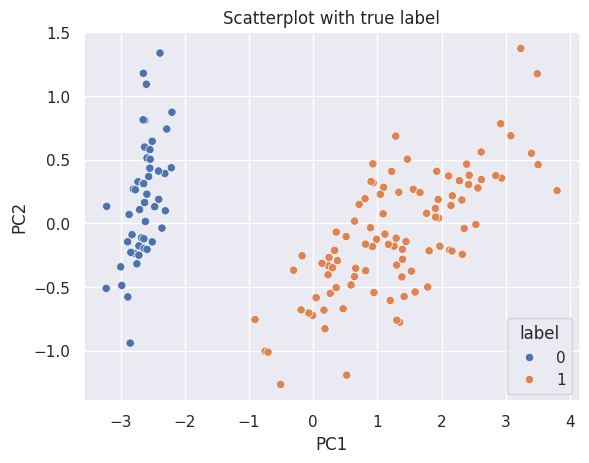

In [13]:
clusterer = hdbscan.HDBSCAN(
    min_samples=2,
    min_cluster_size=20,
    metric='euclidean'
)
clusterer = clusterer.fit(iris_df[numer_cols].to_numpy())

pca_df['label'] = clusterer.labels_

print_clustering_stats(
    clusterer=clusterer,
    clust_data=iris_df[numer_cols].to_numpy(),
    data_labels=iris_df['label'].to_numpy()
)

sns.scatterplot(pca_df, x='PC1', y='PC2', hue='label')
plt.title('Scatterplot with true label')
# this is actually expected
# this will discover only two groups
# the Hdbscan will have hard time separating these groups
# because you can see that we have a data point bridge connecting these groups

<Axes: ylabel='distance'>

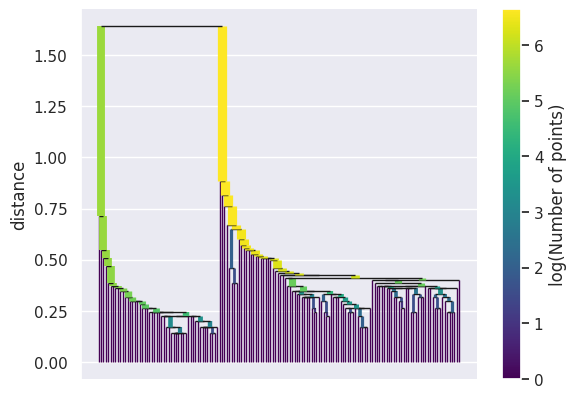

In [14]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
# we might even be able to use the dendrogram in order to split our groups

ARI : 0.7426819236947618
ARI sub : 0.9376636738207378
noise size : 23
Silouethe : 0.4017811646609609
Silouethe sub : 0.5440347603184669
DBCV : 0.12879229791577737


Text(0.5, 1.0, 'Scatterplot with true label')

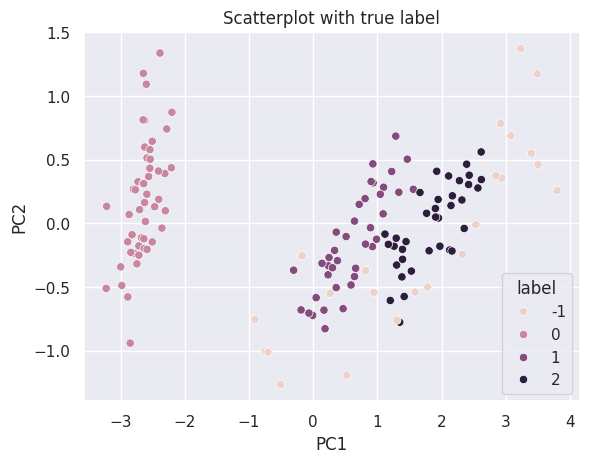

In [15]:
clusterer = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=30,
    metric='euclidean',
    cluster_selection_method='leaf',
)
clusterer = clusterer.fit(iris_df[numer_cols].to_numpy())

pca_df['label'] = clusterer.labels_

print_clustering_stats(
    clusterer=clusterer,
    clust_data=iris_df[numer_cols].to_numpy(),
    data_labels=iris_df['label'].to_numpy()
)

sns.scatterplot(pca_df, x='PC1', y='PC2', hue='label')
plt.title('Scatterplot with true label')
# the leaf method will actually help us at splitting these data points to some extent
# the price we have to pay is that some of the data points will be declared as noise